In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

# The next libraries are to plot DAGs
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel

---

In [2]:
ALPHA_LEVEL = 0.11

In [3]:
Dat = pd.read_csv('Data/milk.csv', sep=';')

In [4]:
Dat.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


A popular hypothesis has it that primates with larger brains produce more energetic milk, so that brains can grow quickly. The question here is to what extent energy content of milk, measured here by kilocalories, is related to the percentage of brain mass that is neocortex. We'll end up needing female body mass as well.

In [5]:
Dat = Dat[['neocortex.perc', 'mass', 'kcal.per.g']]

# We take out the null values for the newcortex variable
Dat = Dat[~Dat['neocortex.perc'].isnull()].reset_index(drop=True)

# We take the logarithm of the mass
Dat['LogMass'] = np.log(Dat['mass'])

Dat = Dat.rename(columns={'neocortex.perc':'Newcortex', 'kcal.per.g':'Energy'})

In [6]:
Dat.head()

,Newcortex,mass,Energy,LogMass
0,55.16,1.95,0.49,0.667829
1,64.54,5.25,0.47,1.658228
2,64.54,5.37,0.56,1.680828
3,67.64,2.51,0.89,0.920283
4,68.85,0.68,0.92,-0.385662


We standardize the variables

In [7]:
Dat['NewcortexStandard'] = (Dat['Newcortex'] - Dat['Newcortex'].mean()) / Dat['Newcortex'].std()
Dat['EnergyStandard'] = (Dat['Energy'] - Dat['Energy'].mean()) / Dat['Energy'].std()
Dat['LogMassStandard'] = (Dat['LogMass'] - Dat['LogMass'].mean()) / Dat['LogMass'].std()

### Model to predict energy given newcortex percentage

In [8]:
with pm.Model() as ModelEnergyGivenNewcortex:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaN = pm.Normal('BetaN', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaN * Dat['NewcortexStandard'])

    Energy = pm.Normal('Energy', mu=Mu, sigma=Sigma, observed=Dat['EnergyStandard'])

    TraceEnergyGivenNewcortex = pm.sample()
    TraceEnergyGivenNewcortex.extend(pm.sample_posterior_predictive(TraceEnergyGivenNewcortex))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaN, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Energy]


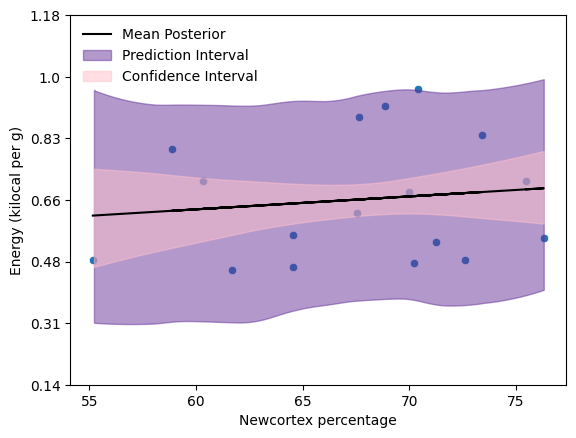

In [9]:
sns.scatterplot(x=Dat['Newcortex'], y=Dat['EnergyStandard'])

plt.plot(
    Dat['Newcortex']
    , TraceEnergyGivenNewcortex.posterior.Mu.mean(('chain', 'draw'))
    , label="Mean Posterior"
    , color='k'
)

az.plot_hdi(
    Dat['Newcortex']
    , TraceEnergyGivenNewcortex.posterior_predictive.Energy
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
)

az.plot_hdi(
    Dat['Newcortex']
    , TraceEnergyGivenNewcortex.posterior.Mu
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
)

plt.legend(frameon=False)
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Energy'].std() + Dat['Energy'].mean(), 2))
_ = plt.xlabel("Newcortex percentage")
_ = plt.ylabel("Energy (kilocal per g)")

# plt.savefig('D_given_A.png', transparent=True)

Total effect of newcortex percentage over the energy

In [10]:
az.summary(TraceEnergyGivenNewcortex, var_names='BetaN', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaN,0.12,0.23,-0.23,0.5


### Model to predict energy given body mass

In [11]:
with pm.Model() as ModelEnergyGivenMass:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * Dat['LogMassStandard'])

    Energy = pm.Normal('Energy', mu=Mu, sigma=Sigma, observed=Dat['EnergyStandard'])

    TraceEnergyGivenMass = pm.sample()
    TraceEnergyGivenMass.extend(pm.sample_posterior_predictive(TraceEnergyGivenMass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaM, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Energy]


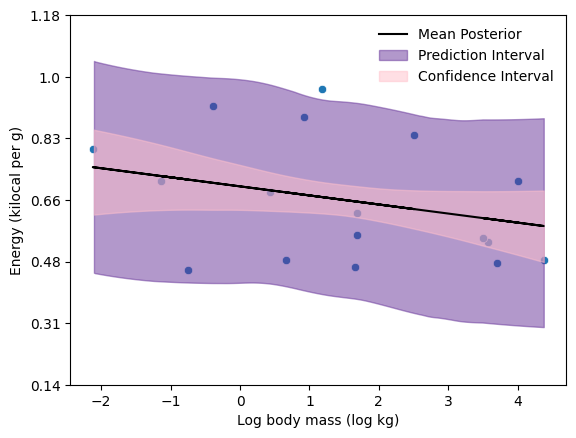

In [12]:
sns.scatterplot(x=Dat['LogMass'], y=Dat['EnergyStandard'])

plt.plot(
    Dat['LogMass']
    , TraceEnergyGivenMass.posterior.Mu.mean(('chain', 'draw'))
    , label="Mean Posterior"
    , color='k'
)

az.plot_hdi(
    Dat['LogMass']
    , TraceEnergyGivenMass.posterior_predictive.Energy
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
)

az.plot_hdi(
    Dat['LogMass']
    , TraceEnergyGivenMass.posterior.Mu
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
)

plt.legend(frameon=False)
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Energy'].std() + Dat['Energy'].mean(), 2))
_ = plt.xlabel("Log body mass (log kg)")
_ = plt.ylabel("Energy (kilocal per g)")

# plt.savefig('D_given_A.png', transparent=True)

Total effect of log-mass body over energy

In [13]:
az.summary(TraceEnergyGivenMass, var_names='BetaM', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaM,-0.28,0.22,-0.63,0.06


### Model to predict energy given newcortex percentage and body mass

In [14]:
with pm.Model() as ModelEnergyGivenNewcortexAndMass:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    BetaN = pm.Normal('BetaN', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * Dat['LogMassStandard'] + BetaN * Dat['NewcortexStandard'])

    Energy = pm.Normal('Energy', mu=Mu, sigma=Sigma, observed=Dat['EnergyStandard'])

    TraceEnergyGivenNewcortexAndMass = pm.sample()
    TraceEnergyGivenNewcortexAndMass.extend(pm.sample_posterior_predictive(TraceEnergyGivenNewcortexAndMass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaM, BetaN, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [Energy]


Direct effect of newcortex percentage and body mass on energy

In [15]:
az.summary(TraceEnergyGivenNewcortexAndMass, var_names=['BetaN', 'BetaM'], kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaN,0.58,0.25,0.18,0.98
BetaM,-0.68,0.26,-1.07,-0.25


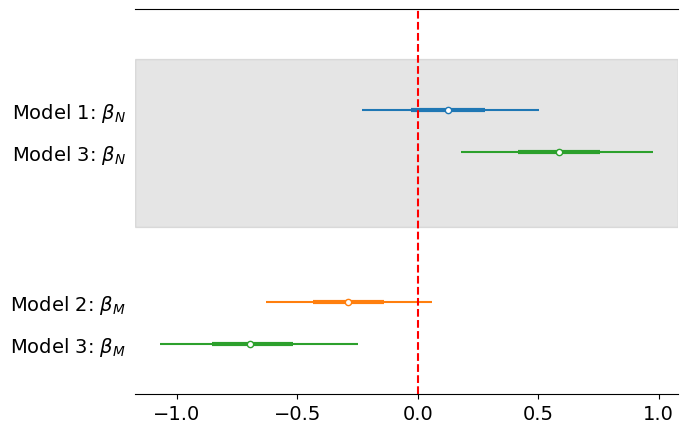

In [16]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"BetaN": r"$\beta_N$", "BetaM": r"$\beta_M$"})

ax = az.plot_forest(
    [TraceEnergyGivenNewcortex, TraceEnergyGivenMass, TraceEnergyGivenNewcortexAndMass]
    , model_names = ["Model 1", "Model 2", "Model 3"]
    , var_names=['BetaN', 'BetaM']
    , combined=True
    , figsize=(7,5)
    , labeller=labeller
    , legend=False
    , hdi_prob=1-ALPHA_LEVEL
)

ax[0].set_title('')
plt.axvline(0, color='r', linestyle='--')

# plt.savefig('DivorcePlotForest.png', transparent=True, bbox_inches='tight')

---

### Posterior predictive plot

In [17]:
EnergyPosteriorPredictive = az.summary(
    TraceEnergyGivenNewcortexAndMass
    , kind='stats'
    , group='posterior_predictive'
    , hdi_prob=1-ALPHA_LEVEL
).reset_index(drop=True)

In [18]:
Dat = pd.concat([Dat, EnergyPosteriorPredictive], axis=1)

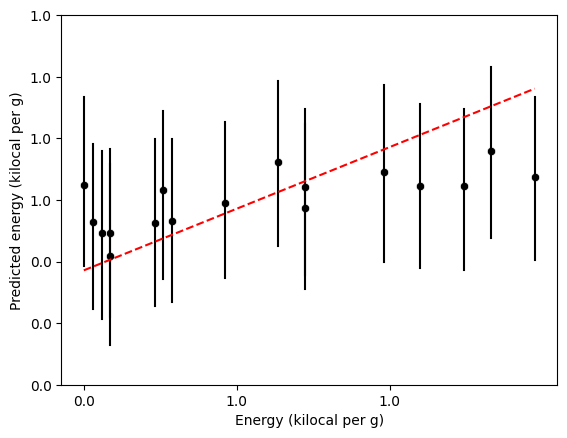

In [19]:
sns.scatterplot(data=Dat, x='EnergyStandard', y='mean', color='k')

for i in range(len(Dat)):
    plt.plot(
        [Dat.loc[i, 'EnergyStandard'], Dat.loc[i, 'EnergyStandard']]
        , [Dat.loc[i, 'hdi_' + str((ALPHA_LEVEL / 2) * 100) + '%'], Dat.loc[i, 'hdi_' + str((1 - ALPHA_LEVEL / 2) * 100) + '%']]
        , color='k'
    )
    
plt.plot(
    [Dat['EnergyStandard'].min(), Dat['EnergyStandard'].max()]
    , [Dat['EnergyStandard'].min(), Dat['EnergyStandard'].max()]
    , color='r'
    , linestyle='--'
)

_ = plt.xlabel("Energy (kilocal per g)")
_ = plt.ylabel("Predicted energy (kilocal per g)")
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Energy'].std() + Dat['Energy'].mean()))
_ = plt.xticks(
    np.arange(Dat['EnergyStandard'].min(), Dat['EnergyStandard'].max())
    , np.round(np.arange(Dat['EnergyStandard'].min(), Dat['EnergyStandard'].max()) * Dat['Energy'].std() + Dat['Energy'].mean())
)

---

## Residual plots

We calculate two more regression models $N\rightarrow M$ and $M\rightarrow N$.

### Model to predict mass given newcortex

In [20]:
with pm.Model() as ModelMassGivenNewcortex:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    Beta = pm.Normal('Beta', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + Beta * Dat['NewcortexStandard'])

    LogMass = pm.Normal('LogMass', mu=Mu, sigma=Sigma, observed=Dat['LogMassStandard'])

    TraceMassGivenNewcortex = pm.sample()
    TraceMassGivenNewcortex.extend(pm.sample_posterior_predictive(TraceMassGivenNewcortex))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [LogMass]


In [21]:
az.summary(TraceMassGivenNewcortex, var_names='Beta', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
Beta,0.66,0.17,0.37,0.93


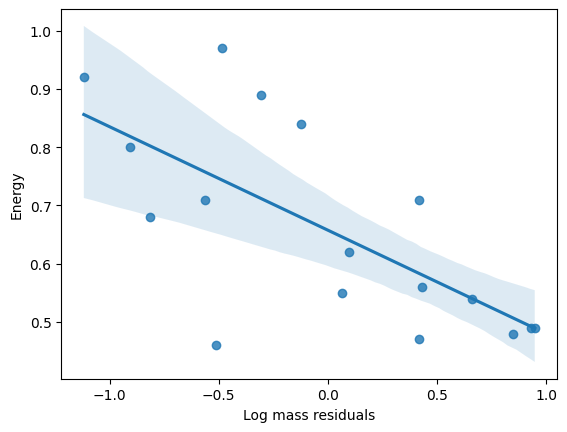

In [22]:
Dat['LogMassStandardResiduals'] = Dat['LogMassStandard'] - TraceMassGivenNewcortex.posterior.Mu.mean(axis=(0,1))
sns.regplot(Dat, x='LogMassStandardResiduals', y='Energy')

_ = plt.xlabel("Log mass residuals")
_ = plt.ylabel("Energy")

### Model to predict newcortex given mass

In [23]:
with pm.Model() as ModelNewcortexGivenMass:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    Beta = pm.Normal('Beta', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + Beta * Dat['LogMassStandard'])

    Newcortex = pm.Normal('Newcortex', mu=Mu, sigma=Sigma, observed=Dat['NewcortexStandard'])

    TraceNewcortexGivenMass = pm.sample()
    TraceNewcortexGivenMass.extend(pm.sample_posterior_predictive(TraceNewcortexGivenMass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Newcortex]


In [24]:
az.summary(TraceNewcortexGivenMass, var_names='Beta', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
Beta,0.66,0.18,0.39,0.95


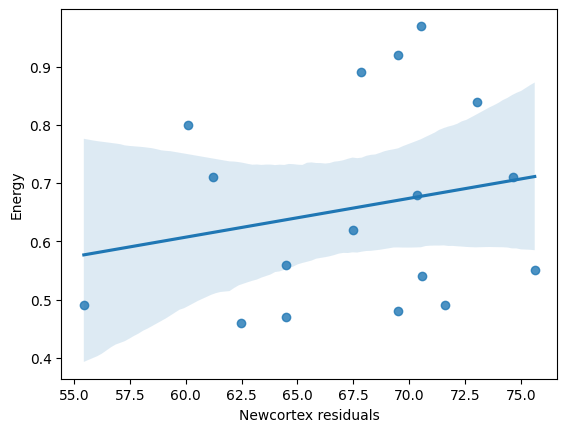

In [25]:
Dat['NewcortexResiduals'] = Dat['Newcortex'] - TraceNewcortexGivenMass.posterior.Mu.mean(axis=(0,1))
sns.regplot(Dat, x='NewcortexResiduals', y='Energy')

_ = plt.xlabel("Newcortex residuals")
_ = plt.ylabel("Energy")

---

There are at least three DAGs consistent with this data.

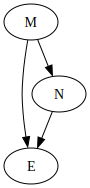

In [26]:
Dag1 = CausalGraphicalModel(nodes=["M", "N", "E"], edges=[("M", "N"), ("M", "E"), ("N", "E")])
Dag1.draw()

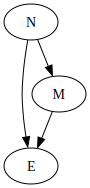

In [27]:
Dag2 = CausalGraphicalModel(nodes=["M", "N", "E"], edges=[("N", "M"), ("M", "E"), ("N", "E")])
Dag2.draw()

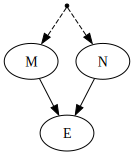

In [28]:
Dag3 = CausalGraphicalModel(nodes=["M", "N", "E"], edges=[("M", "E"), ("N", "E")], latent_edges=[("M", "N")])
Dag3.draw()

---

### Counterfactual plots

Suppose that the third graph is the right one

We define the causal model

In [29]:
with pm.Model() as ModelCausal:

    NewcortexData = pm.MutableData('NewcortexData', Dat['NewcortexStandard'].to_numpy())
    MassData = pm.MutableData('MassData', Dat['LogMassStandard'].to_numpy())

    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    BetaN = pm.Normal('BetaN', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * MassData + BetaN * NewcortexData)

    Energy = pm.Normal('Energy', mu=Mu, sigma=Sigma, observed=Dat['EnergyStandard'])

    TraceCausal = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaM, BetaN, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


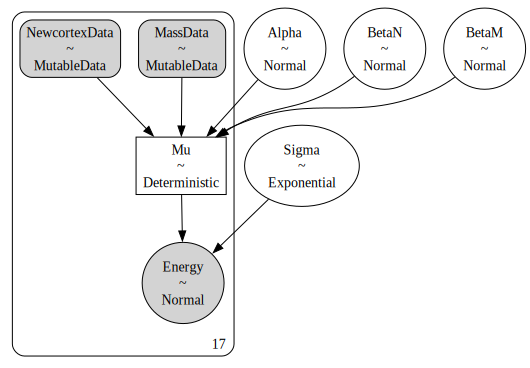

In [30]:
pm.model_to_graphviz(ModelCausal)

Manipulating the body mass

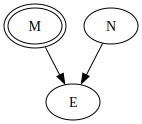

In [31]:
Dag3.do('M').draw()

Manipulating the median age at marriage

In [32]:
MassCounterfactual = np.linspace(Dat['LogMassStandard'].min(), Dat['LogMassStandard'].max(), len(Dat))
NewcortexCounterfactual = np.zeros(len(Dat))

In [33]:
with ModelCausal:
    pm.set_data({'MassData': MassCounterfactual, 'NewcortexData': NewcortexCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal)

Sampling: [Energy]


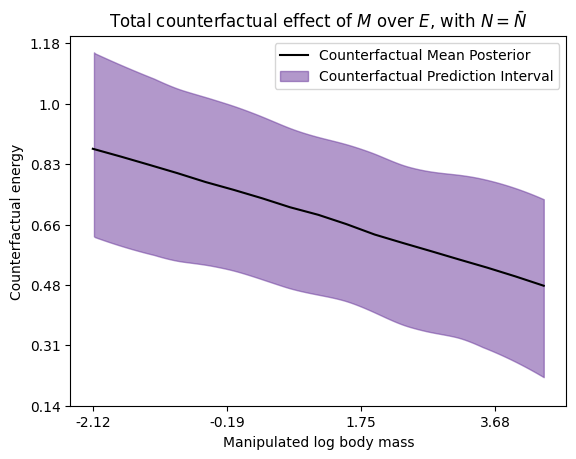

In [34]:
plt.plot(
    MassCounterfactual
    , Counterfactual.posterior_predictive.Energy.mean(('chain', 'draw'))
    , label="Counterfactual Mean Posterior"
    , color='k'
)

az.plot_hdi(
    MassCounterfactual
    , Counterfactual.posterior_predictive.Energy
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Counterfactual Prediction Interval"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Energy'].std() + Dat['Energy'].mean(), 2))
_ = plt.xticks(
    np.arange(Dat['LogMassStandard'].min(), Dat['LogMassStandard'].max()),
    np.round(
        np.arange(Dat['LogMassStandard'].min(), Dat['LogMassStandard'].max()) * Dat['LogMass'].std() + Dat['LogMass'].mean()
        , 2
    )
)
_ = plt.xlabel("Manipulated log body mass")
_ = plt.ylabel("Counterfactual energy")
_ = plt.title(r"Total counterfactual effect of $M$ over $E$, with $N=\bar{N}$")

# plt.savefig('M_given_A.png', transparent=True)

Manipulating the newcortex percentage

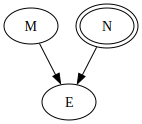

In [35]:
Dag3.do('N').draw()

Manipulating the median age at marriage

In [36]:
MassCounterfactual = np.zeros(len(Dat))
NewcortexCounterfactual = np.linspace(Dat['NewcortexStandard'].min(), Dat['NewcortexStandard'].max(), len(Dat))

In [37]:
with ModelCausal:
    pm.set_data({'MassData': MassCounterfactual, 'NewcortexData': NewcortexCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal)

Sampling: [Energy]


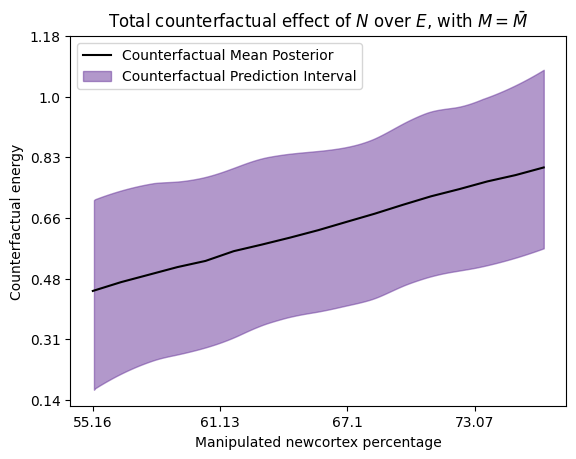

In [38]:
plt.plot(
    NewcortexCounterfactual
    , Counterfactual.posterior_predictive.Energy.mean(('chain', 'draw'))
    , label="Counterfactual Mean Posterior"
    , color='k'
)

az.plot_hdi(
    NewcortexCounterfactual
    , Counterfactual.posterior_predictive.Energy
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Counterfactual Prediction Interval"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Energy'].std() + Dat['Energy'].mean(), 2))
_ = plt.xticks(
    np.arange(Dat['NewcortexStandard'].min(), Dat['NewcortexStandard'].max()),
    np.round(
        np.arange(Dat['NewcortexStandard'].min(), Dat['NewcortexStandard'].max()) * Dat['Newcortex'].std() + Dat['Newcortex'].mean()
        , 2
    )
)
_ = plt.xlabel("Manipulated newcortex percentage")
_ = plt.ylabel("Counterfactual energy")
_ = plt.title(r"Total counterfactual effect of $N$ over $E$, with $M=\bar{M}$")

# plt.savefig('M_given_A.png', transparent=True)